In [1]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, write_test_data, gpt_prediction, eval_response, results_path

output_dir = results_path / "sentence_cap_short"
if not output_dir.exists():
    output_dir.mkdir(parents=True)
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 78,
 'all_upper': 59,
 'animate': 1,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'long': 108,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'short': 92,
 'start_cap': 121,
 'start_consonant': 171,
 'start_lower': 79,
 'start_the': 57,
 'start_vowel': 29}


In [2]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["start_cap", "short"]
tags_false = ["start_lower", "long"]
adversarial_true = ["start_lower", "short"]
adversarial_false = ["start_cap", "long"]
tags_common = []
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common, true_comb="AND", false_comb="AND")
adv_positives, adv_negatives = create_dataset(dataset, adversarial_true, adversarial_false, tags_common, true_comb="AND", false_comb="AND")

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"adversarial_true: {adversarial_true}\n")
    f.write(f"adversarial_false: {adversarial_false}\n")
    f.write(f"tags_common: {tags_common}\n")

print(len(positives), len(negatives))
print(len(adv_positives), len(adv_negatives))

54 41
38 67


In [3]:
pprint(positives)

[{'input': 'SCATTERED ACROSS THE VAST DESERT',
  'label': True,
  'tags': ['all_upper',
           'gpt4',
           'short',
           'nature',
           'start_consonant',
           'start_cap',
           'odd_words',
           'fragment_verb']},
 {'input': 'WHISPERING SECRETS TO THE NIGHT',
  'label': True,
  'tags': ['all_upper',
           'fragment_verb',
           'odd_words',
           'gpt4',
           'short',
           'start_consonant',
           'start_cap']},
 {'input': 'THE OLYMPICS CELEBRATE ATHLETIC EXCELLENCE.',
  'label': True,
  'tags': ['all_upper',
           'proper_noun',
           'gpt4',
           'sentence',
           'short',
           'start_consonant',
           'start_cap',
           'odd_words',
           'start_the']},
 {'input': 'Glowing embers in the fireplace',
  'label': True,
  'tags': ['odd_words',
           'gpt4',
           'fragment_subject',
           'short',
           'start_consonant',
           'start_cap']},
 {'inp

In [4]:
pprint(negatives)

[{'input': 'java is widely used in enterprise applications.',
  'label': False,
  'tags': ['proper_noun',
           'gpt4',
           'sentence',
           'start_consonant',
           'long',
           'odd_words',
           'all_lower',
           'start_lower']},
 {'input': 'illuminated by the soft glow of lanterns',
  'label': False,
  'tags': ['odd_words',
           'all_lower',
           'gpt4',
           'start_lower',
           'start_vowel',
           'fragment_verb',
           'long']},
 {'input': 'i enjoy hiking in the peaceful woods.',
  'label': False,
  'tags': ['gpt4',
           'sentence',
           'nature',
           'start_vowel',
           'long',
           'odd_words',
           'all_lower',
           'start_lower']},
 {'input': 'rainy days are perfect for cozy reading.',
  'label': False,
  'tags': ['odd_words',
           'all_lower',
           'gpt4',
           'sentence',
           'start_lower',
           'start_consonant',
           'l

In [6]:
sample_counts = [3]
response_jsons = []
for c in sample_counts:
    write_test_data(positives, negatives, c, output_dir)
    in_context_prompt = open(output_dir / f"in_context_prompt_{c}.txt").read()
    test_prompt = open(output_dir / f"test_prompt_{c}.txt").read()
    test_samples = json.load(open(output_dir / f"test_samples_{c}.json"))
    response_json = gpt_prediction(in_context_prompt, test_prompt, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{c}.json", "w"))
    response_jsons.append(response_json)

In [7]:
sample_counts = [3, 5, 10, 15]
response_jsons = [json.load(open(output_dir / f"response_{c}.json")) for c in sample_counts]
test_samples = [json.load(open(output_dir / f"test_samples_{c}.json")) for c in sample_counts]

results = []
responses = []
for r, t in zip(response_jsons, test_samples):
    response, result = eval_response(r, t)
    results.append(result)
    responses.append(response)

In [13]:
for c, r in zip(sample_counts, results):
    r["in_context_count"] = c
pprint(results)

[{'accuracy': 0.8157894736842105,
  'correct': 62,
  'corrupted': 0,
  'in_context_count': 3,
  'incorrect': 14,
  'mismatch': 0,
  'total': 76},
 {'accuracy': 0.8333333333333334,
  'correct': 60,
  'corrupted': 0,
  'in_context_count': 5,
  'incorrect': 12,
  'mismatch': 0,
  'total': 72},
 {'accuracy': 0.8548387096774194,
  'correct': 53,
  'corrupted': 0,
  'in_context_count': 10,
  'incorrect': 9,
  'mismatch': 0,
  'total': 62},
 {'accuracy': 0.8461538461538461,
  'correct': 44,
  'corrupted': 0,
  'in_context_count': 15,
  'incorrect': 8,
  'mismatch': 0,
  'total': 52}]


In [14]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

                   correct  mismatch  incorrect  corrupted  test_total
in_context_count                                                      
3                 0.815789       0.0   0.184211        0.0    0.962025
5                 0.833333       0.0   0.166667        0.0    0.911392
10                0.854839       0.0   0.145161        0.0    0.784810
15                0.846154       0.0   0.153846        0.0    0.658228


Text(0.5, 1.0, ' (n=79, T=1)')

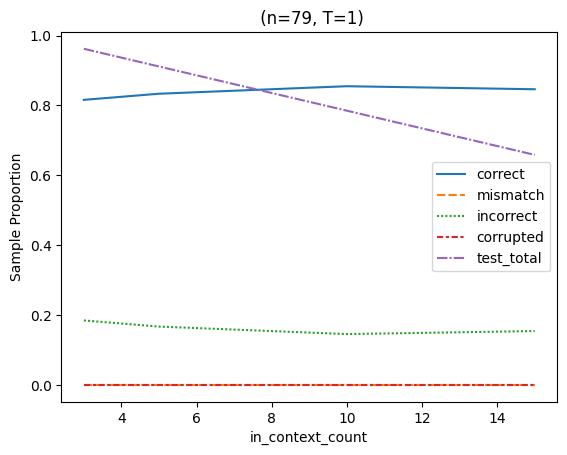

In [17]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)
total_samples = df["total"].max() + df["in_context_count"].min()

for col in df.columns:
    if col == "total":
        df[col] /= total_samples
    elif col == "in_context_count":
        continue
    else:
        df[col] /= df["total"]
df["test_total"] = df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("in_context_count", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f" (n={total_samples}, T=1)")